<a href="https://colab.research.google.com/github/sudolt/CS290/blob/master/%F0%9F%90%BC2_ImageRec_Sudol%2CWu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<small><font color=gray>Notebook author: <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Oleg Melnikov</a>, ©<a href="https://apps.ep.jhu.edu/course-homepages/3765-605-742-deep-neural-networks" target="_blank">JHU</a> 2021 onwards</font></small><hr style="margin:0;background-color:silver">

# **[🏆🪐Venus vs Mars](https://www.kaggle.com/competitions/32822venus-vs-mars/rules)**

See [**instructions**](https://colab.research.google.com/drive/1riOGrE_Fv-yfIbM5V4pgJx4DWcd92cZr#scrollTo=ITaPDPIQEgXV) for running and naming your Colab notebooks.

**(Optioal) CONSENT.** If ok with sharing your Colab for educational purposes, please check the box below with "X".

<mark>[ .X. ]</mark> We consent to sharing our Colab (after the assignment ends) with other students/instructors for educational purpose. We understand that sharing is optional and this decision will not affect our grade in any way. 

In [ ]:
from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if kaggle.json is stored in Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip -q install tensorflow==2.7
!apt -q install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip -q install -U tfds-nightly tensorflow_addons tensorflow > log

     |████████████████████████████████| 665.5 MB 23 kB/s 
Reading package lists...
Building dependency tree...
Reading state information...
libcudnn8 is already the newest version (8.1.0.77-1+cuda11.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.


In [ ]:
!pip -q install --upgrade --force-reinstall --no-deps kaggle > log  # upgrade kaggle package (to avoid a warning)
!mkdir -p ~/.kaggle                               # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
!cp kaggle.json ~/.kaggle/kaggle.json > log       # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                  # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v 32822venus-vs-mars # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download >> log              # download competition dataset as a zip file
!unzip -o *.zip >> log                            # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show           # print public leaderboard

cp: cannot stat 'kaggle.json': No such file or directory
- competition is now set to: 32822venus-vs-mars
Using competition: 32822venus-vs-mars
 teamId  teamName                                submissionDate       score    
-------  --------------------------------------  -------------------  -------  
8967073  🐧5-WeddingCrashers-Acosta, Na           2022-08-08 01:15:37  0.97200  
8964436  🐧1-MadVulcanus-Rice,Sahi,Yoo            2022-08-07 21:13:13  0.96400  
9377735  Richard Phouasalith                     2022-11-06 00:51:20  0.96400  
8453323  JC-Hokies-Rumman, Hogge                 2022-04-11 00:54:33  0.96360  
9390729  ZachWaldman                             2022-11-06 18:01:50  0.96360  
8943901  🐧4-GenderNeutral-Cahill,Rivas           2022-08-08 02:48:27  0.96280  
8973911  🐧2-PlanetClass-Nathanson,Cui            2022-08-08 03:05:59  0.96280  
8989359  🐧6-NonBinary-Nilla,Bollineni            2022-08-08 03:59:56  0.96160  
8964288  🐧3-SolMates-Nguyen,Samman               2022-08-

See [more](https://nvidia.custhelp.com/app/answers/detail/a_id/3751/~/useful-nvidia-smi-queries) about NVIDIA GPU stats. Test your code in (free) Colab. It uses Tesla K80 GPU.

In [ ]:
!nvidia-smi --query-gpu=gpu_name,memory.total,memory.free,memory.used --format=csv

name, memory.total [MiB], memory.free [MiB], memory.used [MiB]
Tesla T4, 15109 MiB, 15109 MiB, 0 MiB


In [ ]:
%%time
%%capture
%reset -f
!pip -q install -U tensorflow_addons plotly > log   # update tfa in case students need to use it
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all" 
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, os
# os.environ['TF_DETERMINISTIC_OPS'] = '1'  # causes an error   https://github.com/tensorflow/tensorflow/issues/38197
import tensorflow_addons as tfa, tensorflow as tf, tensorflow.keras as keras, tensorflow_datasets as tfds
from keras.layers import Flatten, Dense, Dropout, MaxPooling2D, Conv2D, GlobalAveragePooling2D
from keras.models import Sequential
from tensorflow.keras.applications import resnet50, xception, mobilenet, mobilenet_v2, mobilenet_v3
from tensorflow.keras.utils import image_dataset_from_directory as idfd
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60*5): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=5, suppress=True)
pd.set_option('max_columns', 20, 'precision', 2, 'display.max_rows', 4)
tDIR, sDIR = 'train/', 'test/'

CPU times: user 3.21 s, sys: 495 ms, total: 3.71 s
Wall time: 8.3 s


Examples of images from female class

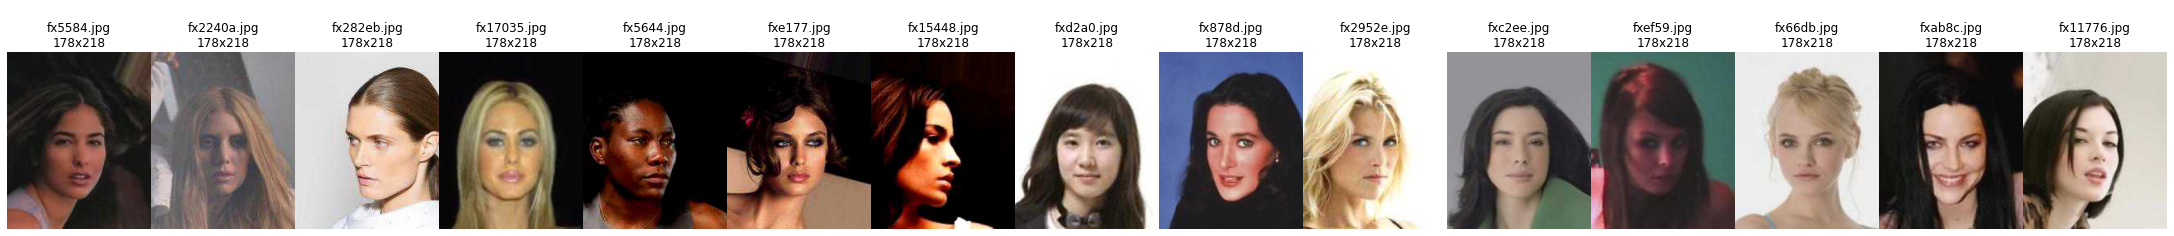

In [ ]:
n, fig = 15, plt.figure(figsize=(30,10));
for i, f in enumerate(np.random.RandomState(0).choice(os.listdir(tDIR+'female/'), n)):
  ax = plt.subplot(1, n, i + 1)
  img = keras.preprocessing.image.load_img(tDIR+'female/'+f);
  _ = ax.set_title(f'\n{f}\n{img.size[0]}x{img.size[1]}');
  _ = plt.axis('off');   _ = plt.tight_layout(pad=0);   _ = plt.imshow(img);

Examples of images from male class

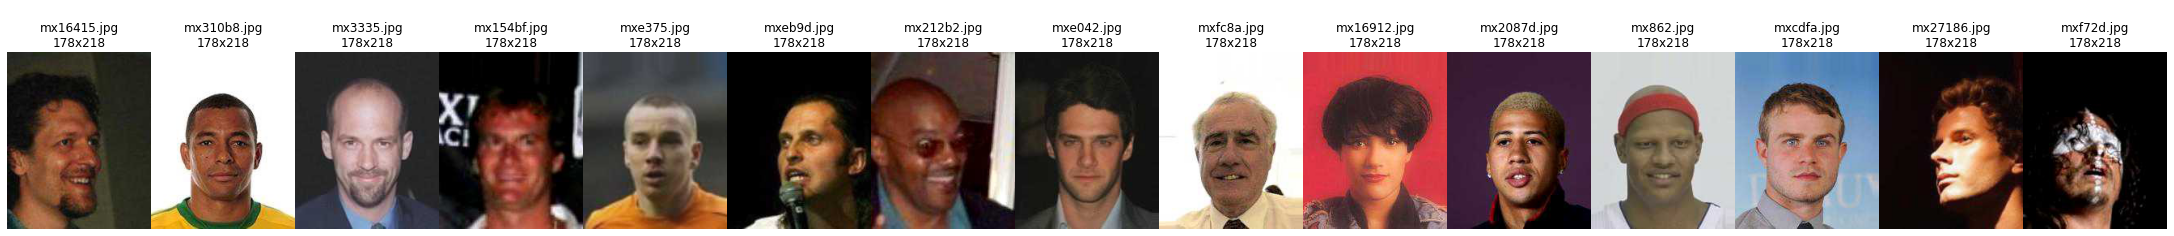

In [ ]:
n, fig = 15, plt.figure(figsize=(30,10));
for i, f in enumerate(np.random.RandomState(0).choice(os.listdir(tDIR+'male/'), n)):
  ax = plt.subplot(1, n, i + 1)
  img = keras.preprocessing.image.load_img(tDIR+'male/'+f);
  _ = ax.set_title(f'\n{f}\n{img.size[0]}x{img.size[1]}');
  _ = plt.axis('off');   _ = plt.tight_layout(pad=0);   _ = plt.imshow(img);

In [ ]:
tmr = Timer() # runtime limit (in seconds). Add all of your code after the timer

⏳ started. You have 300 sec. Good luck!


<font size=5>⏳</font> <strong><font color=orange size=5>Your Code, Documentation, Ideas and Timer - All Start Here...</font></strong>


## **Task 2.1**

**Explain your preprocessing:** i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc.

In an effort to reduce the runtime (which was killing us early on), we ended up testing different batch sizes and image sizes.  We ended up using a batch size of 16 and resized the images to 150 x 150 and cropped them to maintain the aspect ratio (crop_to_aspect_ratio = True).

## **Task 2.2**

**Explain your modeling approach:** ideas you tried and why you thought they would be helpful. Takeaway: how these decisions guided you in modeling.

We started by sampling several different pretrained models.  The largest obstacle was the runtime requirement, which seemed difficult to get under.  Most models went over the runtime during testing, with a few of them also running out of memory.  

Eventually we settled on the EfficientNetV2 series.  From there, we tested each model to find the best compromise of speed and accuracy (measured in binary accuracy).  We maintained a list of the models that we tried, along with the hyperparameters and results, which are in a cell below. 

The following cell loads train/validation/test sets as [TF datasets](https://www.tensorflow.org/datasets), `tDS`, `vDS` and `sDS`, respectively.

In [ ]:
# BS, image_size = 32, (224, 224)  # batch size; image dimensions required by pretrained model
BS, image_size = 16, (150, 150)  # batch size; image dimensions required by pretrained model

# tDS = idfd( tDIR, labels='inferred', label_mode='binary', subset='training', validation_split=0.2,
#            class_names=None, color_mode='rgb', batch_size=BS, image_size=image_size, shuffle=True, seed=0).prefetch(buffer_size=tf.data.AUTOTUNE)  # training dataset
# vDS = idfd( tDIR, labels='inferred', label_mode='binary', subset='validation', validation_split=0.2,
#            class_names=None, color_mode='rgb', batch_size=BS, image_size=image_size, shuffle=True, seed=0).prefetch(buffer_size=tf.data.AUTOTUNE)  # validation dataset
# sDS = idfd( sDIR, labels=None, label_mode='binary', subset=None, validation_split=None,
#            class_names=None, color_mode='rgb', batch_size=BS, image_size=image_size, shuffle=False, seed=0)           # don't prefetch this testing dataset
tDS = idfd( tDIR, labels='inferred', label_mode='binary', subset='training', validation_split=0.2, crop_to_aspect_ratio = True,
           class_names=None, color_mode='rgb', batch_size=BS, image_size=image_size, shuffle=True, seed=0).prefetch(buffer_size=tf.data.AUTOTUNE)  # training dataset
vDS = idfd( tDIR, labels='inferred', label_mode='binary', subset='validation', validation_split=0.2, crop_to_aspect_ratio = True,
           class_names=None, color_mode='rgb', batch_size=BS, image_size=image_size, shuffle=True, seed=0).prefetch(buffer_size=tf.data.AUTOTUNE)  # validation dataset
sDS = idfd( sDIR, labels=None, label_mode='binary', subset=None, validation_split=None, crop_to_aspect_ratio = True,
           class_names=None, color_mode='rgb', batch_size=BS, image_size=image_size, shuffle=False, seed=0)           # don't prefetch this testing dataset
print(tf.reduce_sum([tf.reduce_sum(f) for f in list(tDS.take(1))[0][0][:10]])) # to validate seeding of file sampling

Found 5000 files belonging to 2 classes.
Using 4000 files for training.
Found 5000 files belonging to 2 classes.
Using 1000 files for validation.
Found 5000 files belonging to 1 classes.
tf.Tensor(69106120.0, shape=(), dtype=float32)


One path we looked at was to use efficientnet_v2.EfficientNetV2S due to its fast speed compared with others. The timestopping callback and early stopping callback are also used to help control how much time spend on each porton as well as avoiding overfitting.

We intentionally spent less time on training with transfered layers freezed and more time on training with all layers in the transfer learning process since the performance was improved due to this. Also, the learning rate during post training had to be reduced to small number to avoid corrupting pretrained weights.

The following cell loads train/validation/test sets as TF datasets, tDS, vDS and sDS, respectively.

Since EfficientNetV2B0 gave us a better score on the leaderboard, we went back to that one.

In [ ]:
# TBS,SBS, image_size = 16,16, (150, 150)  # batch size; image dimensions required by pretrained model
# tDS = idfd( tDIR, labels='inferred', label_mode='binary', subset='training', validation_split=0.2,crop_to_aspect_ratio=True,
#            class_names=None, color_mode='rgb', batch_size=TBS, image_size=image_size, shuffle=True, seed=0).prefetch(buffer_size=tf.data.AUTOTUNE)  # training dataset
# vDS = idfd( tDIR, labels='inferred', label_mode='binary', subset='validation', validation_split=0.2,crop_to_aspect_ratio=True,
#            class_names=None, color_mode='rgb', batch_size=TBS, image_size=image_size, shuffle=True, seed=0).prefetch(buffer_size=tf.data.AUTOTUNE)  # validation dataset
# sDS = idfd( sDIR, labels=None, label_mode='binary', subset=None, validation_split=None,crop_to_aspect_ratio=True,
#            class_names=None, color_mode='rgb', batch_size=SBS, image_size=image_size, shuffle=False, seed=0) 

This is your baseline DNN model. Remember to [seed all your experiments](https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development) for reproducibility. [Status of GPU-Determinism in TF](https://github.com/NVIDIA/framework-determinism/blob/master/tensorflow_status.md). 

Below we replace the top layer of the pretrained CNN ([MobileNetV2](https://openaccess.thecvf.com/content_cvpr_2018/papers/Sandler_MobileNetV2_Inverted_Residuals_CVPR_2018_paper.pdf)) and train the new layer only (all remaining pretrained layers are frozen).

In [ ]:
#print(tf.reduce_sum([tf.reduce_sum(f) for f in list(tDS.take(1))[0][0][:10]])) # to validate seeding of file sampling

#Results
####Baseline
Train: loss = 2.7383, accuracy = 0.7080

Test:  loss = 0.4219, accuracy = 0.8073

####Epoch 8
Train:  loss = 0.7719, accuracy = 0.7968

Test:  loss = 0.216, accuracy = 0.9930

####Epoch 16
Ran 478 seconds.

####Inception_v3
Ran 465 seconds.  Abandoning this model for now.

####ConvNeXtBase
Ran very slow.  Out of memory error.

####ConvNeXtLarge
Ran very slow, out of memory.  

####ConvNeXtSmall
605 seconds.  Accuracy 91%

####EfficientNetV2B0
2 Epochs - 136 seconds.  Training = 90.62%, Testing = 95.53%

8 Epochs - 339 seconds.  Training = 93.35%, Testing = 99.67%

4 Epochs - 185 seconds.  Training = 92.90%, Testing = 98.95%

6 Epochs - 253 seconds.  Training = 92.98%, Testing = 99.75%

6 Epochs, 150 AR, 16BS - 212 Seconds.  Training = 92.98%, Testing = 99.37%

8 Epochs, 150 AR, 16BS - 268 Seconds.  Training = 93.45%, Testing = 99.73%

####EfficientNetV2B1
4 Epochs - 261 seconds.  Training = 91.72%, Testing = 98.6%

6 Epochs - 331 seconds.  Training = 92.85%, Testing = 99.23%

6 Epochs, 16BS, 150AR - 264 seconds.  Training = 92.75%, Testing = 99.15%

8 Epochs, 16BS, 150AR - 320 seconds.  Training = 93.85%, Testing = 99.52%

####EfficientNetV2B2
4 Epochs - 252 seconds.  Training = 92.08%, Testing = 98.68%

####EfficientNetV2B3
8 Epochs, 16BS, 150AR - 411 seconds.  Training = 93.37%, Testing = 99.45%

Baseline Model

In [ ]:
# %%time
# tf.random.set_seed(0)   # always seed your experiments
# Init = keras.initializers.RandomNormal(seed=0) # seed all that you can

# pm = mobilenet_v2.MobileNetV2(weights="imagenet", include_top=False)         # pretrained Xception model
# avg = GlobalAveragePooling2D(data_format='channels_last')(pm.output)  # collapse spatial dimensions
# output = Dense(1, activation="sigmoid", kernel_initializer=Init)(avg)
# pm1 = keras.Model(inputs=pm.input, outputs=output)
# for l in pm.layers: l.trainable = False                               # freeze layers from training

# optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
# pm1.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# hist = pm1.fit(tDS, epochs=2, validation_data=vDS)     # For BS=32, 2xCPU: 15min/epoch, GPU: 15sec/epoch  (60x faster)


In [ ]:
# import tensorflow_addons as tfa

In [ ]:
# timeStopping = tfa.callbacks.TimeStopping(seconds=25, verbose=1)
# early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

In [ ]:
#%%time
# tf.random.set_seed(0)   # always seed your experiments
# Init = keras.initializers.RandomNormal(seed=0) # seed all that you can

#pm = mobilenet_v2.MobileNetV2(weights="imagenet", include_top=False)         # Transfer learning: pretrained mobilenet_v2 model
#pm = xception.Xception(weights="imagenet", include_top=False)         # Transfer learning: pretrained xception model, https://www.tensorflow.org/api_docs/python/tf/keras/applications/xception/Xception
# pm = efficientnet_v2.EfficientNetV2S(weights="imagenet", include_top=False)  
# avg = GlobalAveragePooling2D(data_format='channels_last')(pm.output)  # added layer:collapse spatial dimensions by performming average over the whole feature map
# output = Dense(1, activation="sigmoid", kernel_initializer=Init)(avg)# added layer : output layer for binary classification
# pm1 = keras.Model(inputs=pm.input, outputs=output)#Keras Functional API
# for l in pm.layers: l.trainable = False                               # Transfer learning: freeze layers from training

# optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
# pm1.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# hist = pm1.fit(tDS, epochs=1000, validation_data=vDS,callbacks=[timeStopping,early_stopping_cb]) 

Epoch 1/1000
250/250 [==============================] - 32s 74ms/step - loss: 0.4685 - accuracy: 0.8690 - val_loss: 0.3173 - val_accuracy: 0.9040
Timed stopping at epoch 1 after training for 0:00:25
Below we post-train all pre-trained layers after unlocking them.

In [ ]:
from keras.applications import inception_v3

tf.random.set_seed(0)   # always seed your experiments
Init = keras.initializers.RandomNormal(seed=0) # seed all that you can

in_shape = (224, 224, 3)

# epoch = 2
# epoch = 4
# epoch = 6
epoch = 8
# epoch = 16

# pm = mobilenet_v2.MobileNetV2(weights="imagenet", include_top=False)         # pretrained Xception model
# pm = inception_v3.InceptionV3(weights="imagenet", include_top=False, input_shape = in_shape)   
# pm = tf.keras.applications.convnext.ConvNeXtBase(weights="imagenet", include_top=False)
# pm = tf.keras.applications.convnext.ConvNeXtLarge(weights="imagenet", include_top=False)
# pm = tf.keras.applications.convnext.ConvNeXtSmall(weights="imagenet", include_top=False) 
pm = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(weights="imagenet", include_top=False)
# pm = tf.keras.applications.efficientnet_v2.EfficientNetV2B1(weights="imagenet", include_top=False)
# pm = tf.keras.applications.efficientnet_v2.EfficientNetV2B2(weights="imagenet", include_top=False)
# pm = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(weights="imagenet", include_top=False)


avg = GlobalAveragePooling2D(data_format='channels_last')(pm.output)  # collapse spatial dimensions
output = Dense(1, activation="sigmoid", kernel_initializer=Init)(avg)
pm1 = keras.Model(inputs=pm.input, outputs=output)
for l in pm.layers: l.trainable = False                               # freeze layers from training

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
pm1.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["binary_accuracy"])
# hist = pm1.fit(tDS, epochs=2, validation_data=vDS)     # For BS=32, 2xCPU: 15min/epoch, GPU: 15sec/epoch  (60x faster)
hist = pm1.fit(tDS, epochs=epoch, validation_data=vDS) 

52606240/52606240 [==============================] - 3s 0us/step
Epoch 1/8
250/250 [==============================] - 38s 55ms/step - loss: 0.6132 - binary_accuracy: 0.8608 - val_loss: 0.3741 - val_binary_accuracy: 0.8980
Epoch 2/8
250/250 [==============================] - 12s 47ms/step - loss: 0.2830 - binary_accuracy: 0.9005 - val_loss: 0.2903 - val_binary_accuracy: 0.9130
Epoch 3/8
250/250 [==============================] - 11s 42ms/step - loss: 0.2202 - binary_accuracy: 0.9193 - val_loss: 0.2630 - val_binary_accuracy: 0.9100
Epoch 4/8
250/250 [==============================] - 11s 42ms/step - loss: 0.2094 - binary_accuracy: 0.9155 - val_loss: 0.2586 - val_binary_accuracy: 0.9070
Epoch 5/8
250/250 [==============================] - 11s 42ms/step - loss: 0.1842 - binary_accuracy: 0.9285 - val_loss: 0.2565 - val_binary_accuracy: 0.9030
Epoch 6/8
250/250 [==============================] - 11s 42ms/step - loss: 0.1805 - binary_accuracy: 0.9337 - val_loss: 0.2551 - val_binary_accuracy: 

Below we post-train all pre-trained layers after unlocking them.

In [ ]:
# timeStopping1 = tfa.callbacks.TimeStopping(seconds=200, verbose=1)
# early_stopping_cb1 = keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

In [ ]:
#%%time
# for l in pm.layers: l.trainable = True      # allow training
# opt = keras.optimizers.SGD(learning_rate=0.002, momentum=0.9, 
#                            #decay=0.001
#                            )# post train usually use smaller rate to avoid corrupting the the weights in the pretrainied layer
# pm1.compile(loss="binary_crossentropy", optimizer=opt, metrics=['binary_accuracy'])
# hist = pm1.fit(tDS, epochs=1000, validation_data=vDS,callbacks=[timeStopping1,early_stopping_cb1])

Epoch 1/1000
250/250 [==============================] - 63s 175ms/step - loss: 0.4151 - binary_accuracy: 0.8388 - val_loss: 0.2794 - val_binary_accuracy: 0.8920
Epoch 2/1000
250/250 [==============================] - 40s 161ms/step - loss: 0.1405 - binary_accuracy: 0.9477 - val_loss: 0.2310 - val_binary_accuracy: 0.9230
Epoch 3/1000
250/250 [==============================] - 40s 160ms/step - loss: 0.0744 - binary_accuracy: 0.9705 - val_loss: 0.2436 - val_binary_accuracy: 0.9210
Epoch 4/1000
250/250 [==============================] - 41s 162ms/step - loss: 0.0574 - binary_accuracy: 0.9800 - val_loss: 0.2217 - val_binary_accuracy: 0.9360
Epoch 5/1000
250/250 [==============================] - 40s 160ms/step - loss: 0.0335 - binary_accuracy: 0.9877 - val_loss: 0.2298 - val_binary_accuracy: 0.9340
Timed stopping at epoch 5 after training for 0:03:20

Compile and export predictions:

In [ ]:
for l in pm.layers: l.trainable = True      # allow training
opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=0.001)
pm1.compile(loss="binary_crossentropy", optimizer=opt, metrics=['binary_accuracy'])
# hist = pm1.fit(tDS, epochs=2, validation_data=vDS)
hist = pm1.fit(tDS, epochs=epoch, validation_data=vDS)

Epoch 1/8
250/250 [==============================] - 48s 128ms/step - loss: 0.5732 - binary_accuracy: 0.7830 - val_loss: 0.3139 - val_binary_accuracy: 0.8710
Epoch 2/8
250/250 [==============================] - 29s 117ms/step - loss: 0.2108 - binary_accuracy: 0.9125 - val_loss: 0.2000 - val_binary_accuracy: 0.9190
Epoch 3/8
250/250 [==============================] - 30s 119ms/step - loss: 0.1237 - binary_accuracy: 0.9535 - val_loss: 0.2105 - val_binary_accuracy: 0.9230
Epoch 4/8
250/250 [==============================] - 30s 119ms/step - loss: 0.0877 - binary_accuracy: 0.9685 - val_loss: 0.2116 - val_binary_accuracy: 0.9260
Epoch 5/8
250/250 [==============================] - 29s 117ms/step - loss: 0.0540 - binary_accuracy: 0.9805 - val_loss: 0.2064 - val_binary_accuracy: 0.9340
Epoch 6/8
250/250 [==============================] - 29s 117ms/step - loss: 0.0433 - binary_accuracy: 0.9862 - val_loss: 0.2107 - val_binary_accuracy: 0.9380
Epoch 7/8
250/250 [==============================] -

Compile and export predictions:

In [ ]:
vIDs = [f.split('/')[1].split('.')[0] for f in sDS.file_paths]   # parse image IDs from file names
pY = pd.DataFrame(pm1.predict(sDS), index=vIDs, columns=['y'])   # predicted targets
ToCSV((pY>0.5)*1, 'EfficientNetV2B0_Epoch8_BS16_150AR')

313/313 [==============================] - 12s 31ms/step


# **References:**

1. Bmarcos. (2018, September 22). Image recognition - gender detection - inceptionv3. Kaggle. Retrieved November 1, 2022, from https://www.kaggle.com/code/bmarcos/image-recognition-gender-detection-inceptionv3 

2. Géron Aurélien. (2019). Hands-on machine learning with scikit-learn, Keras, and tensorflow: Concepts, tools, and techniques to build Intelligent Systems. O'Reilly Media, Incorporated. 

3. Module: Tf.keras.applications | TensorFlow v2.10.0. (n.d.). Retrieved November 1, 2022, from https://www.tensorflow.org/api_docs/python/tf/keras/applications

4. Module: Tf.keras.applications.efficientnet_v2 &nbsp;: &nbsp; tensorflow V2.10.0. TensorFlow. (n.d.). Retrieved November 1, 2022, from https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet_v2

5. Sandler, M., Howard, A., Zhu, M., Zhmoginov, A., & Chen, L.-C. (2018). MobileNetV2: Inverted Residuals and Linear Bottlenecks. 2018 IEEE/CVF Conference on Computer Vision and Pattern Recognition, 4510–4520. https://doi.org/10.1109/CVPR.2018.00474

6. Tan, M., & Le, Q. V. (2021). EfficientNetV2: Smaller Models and Faster Training (arXiv:2104.00298). arXiv. http://arxiv.org/abs/2104.00298

7. TensorFlow Datasets. (n.d.). TensorFlow. Retrieved November 2, 2022, from https://www.tensorflow.org/datasets

<font size=5>⏳</font> <strong><font color=orange size=5>Do not exceed competition's runtime limit!</font></strong>


In [ ]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 411 sec > 300 sec limit!!!


## 💡**Starter Ideas**

1. Try tuning CNN hyperparameters and architecture
1. Other [pre-trained models](https://www.tensorflow.org/api_docs/python/tf/keras/applications) can be faster or more accurate for the given dataset and/or hardware ([benchmarks](https://datascience.stackexchange.com/a/39211/14094))
1. Transforming images via [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)could be faster
1. Identify poorly predicted train images (with near-boundary confidence) and add their augmented versions
1. Identify poorly predicted test images (with near-boundary confidence) and post-train CNN even more on "similar" train images. Similarity can be done in terms of some of the layer(s) of CNN
1. Do you really need all given images? CNN will train faster on a "meaningful" subsample
1. Try ensembling different pretrained CNNs or only their selected layers
1. Try different learning rate for different layers of pretrained models
1. Try cropping instead of resizing images to the fixed $224\times224$ (faces look more naturally if aspect ratio is respected)
1. Try [TPU](https://en.wikipedia.org/wiki/Tensor_Processing_Unit) in Colab. 😮 See [doc example](https://www.tensorflow.org/guide/tpu). Local images should be loaded with [Python I/O](https://stackoverflow.com/a/63147614/3043335), not TF datasets.